In [1]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import random
from tqdm import tqdm
import numpy as np

In [2]:
class ImageNetColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = self.get_image_paths()

    def get_image_paths(self):
        paths = [] 
        # Traverse through the 'Data' directory or root directory
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(('.JPEG', '.jpg', '.png')):  # Add extensions as needed
                    paths.append(os.path.join(root, file))
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open image as RGB
        
        if self.transform:
            image = self.transform(image)
        
        # Convert to LAB color space
        lab_image = rgb2lab(image.permute(1, 2, 0).numpy())
        
        # Normalize L channel to range [-1, 1]
        l_channel = lab_image[:,:,0] / 50.0 - 1.0
        
        # Normalize ab channels to range [-1, 1]
        ab_channels = lab_image[:,:,1:] / 110.0
        
        return torch.from_numpy(l_channel).unsqueeze(0).float(), torch.from_numpy(ab_channels).permute(2, 0, 1).float()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

# Create dataset and dataloader
train_dataset = ImageNetColorizationDataset(root_dir='/notebooks/imageNet_55bg/ILSVRC/Data/DET/train', transform=transform)
test_dataset = ImageNetColorizationDataset(root_dir='/notebooks/imageNet_55bg/ILSVRC/Data/DET/test', transform=transform)
val_dataset = ImageNetColorizationDataset(root_dir='/notebooks/imageNet_55bg/ILSVRC/Data/DET/val', transform=transform)


In [3]:
# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


gray_images, color_images = next(iter(train_loader)) # Should result in shape -> [32, 1, 224, 224], [B, C, W, H]
print(gray_images.shape)
print(color_images.shape)

gray_images, color_images = next(iter(test_loader))
print(gray_images.shape)
print(color_images.shape)

gray_images, color_images = next(iter(val_loader))
print(gray_images.shape)
print(color_images.shape)
        

torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])


In [5]:
train_size = int(0.8 * len(val_dataset))
val_size = len(val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(val_dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=224):
        super(ColorizationNet, self).__init__()
        
        # Use ResNet50 as the encoder (feature extractor)
        resnet = models.resnet50(pretrained=True)
        
        # Modify the first convolutional layer to accept a grayscale image
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        # Change the first convolution layer to accept 1 channel instead of 3
        self.encoder[0] = nn.Conv2d(
            in_channels=1,  # Change from 3 to 1 channel
            out_channels=self.encoder[0].out_channels,
            kernel_size=self.encoder[0].kernel_size,
            stride=self.encoder[0].stride,
            padding=self.encoder[0].padding,
            bias=self.encoder[0].bias
        )
        
        # Initialize the weights of the new first layer with the mean of the original weights
        with torch.no_grad():
            self.encoder[0].weight[:] = resnet.conv1.weight.mean(dim=1, keepdim=True)
        
        # Freeze the encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Decoder (upsampling path)
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 2, kernel_size=3, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )
        
    def forward(self, x):
        # Encode grayscale input
        features = self.encoder(x)
        
        # Decode to ab channels
        ab_output = self.decoder(features)
        
        return ab_output


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize the model
model = ColorizationNet().to(device)


criterion = nn.MSELoss()  # Mean Squared Error for colorization
model


cuda


ColorizationNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0007)
model.load_state_dict(torch.load('/notebooks/best_model.pth', weights_only=True))
num_epochs = 20

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for gray_images, color_images in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            gray_images = gray_images.to(device)
            color_images = color_images.to(device)
            
            optimizer.zero_grad()
            outputs = model(gray_images)
            loss = criterion(outputs, color_images)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * gray_images.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        val_loss = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Model saved with Val Loss: {val_loss:.5f}')
    
    return train_losses, val_losses

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for gray_images, color_images in val_loader:
            gray_images = gray_images.to(device)
            color_images = color_images.to(device)
            
            outputs = model(gray_images)
            loss = criterion(outputs, color_images)
            
            val_loss += loss.item() * gray_images.size(0)
    
    val_loss /= len(val_loader.dataset)
    return val_loss


In [39]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.08it/s]


Epoch 1/20, Train Loss: 0.01663, Val Loss: 0.01617
Model saved with Val Loss: 0.01617


Epoch 2/20:   2%|▏         | 64/2854 [00:11<07:32,  6.16it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2fb79b8fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 2/20:   3%|▎         | 87/2854 [00:15<07:28,  6.17it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2fb79b8fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __d

Epoch 2/20, Train Loss: 0.01629, Val Loss: 0.01601
Model saved with Val Loss: 0.01601


Epoch 3/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.07it/s]


Epoch 3/20, Train Loss: 0.01611, Val Loss: 0.01587
Model saved with Val Loss: 0.01587


Epoch 4/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.08it/s]


Epoch 4/20, Train Loss: 0.01595, Val Loss: 0.01599


Epoch 5/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.07it/s]


Epoch 5/20, Train Loss: 0.01592, Val Loss: 0.01634


Epoch 6/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 6/20, Train Loss: 0.01589, Val Loss: 0.01573
Model saved with Val Loss: 0.01573


Epoch 7/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.08it/s]


Epoch 7/20, Train Loss: 0.01581, Val Loss: 0.01583


Epoch 8/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.07it/s]


Epoch 8/20, Train Loss: 0.01570, Val Loss: 0.01581


Epoch 9/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.08it/s]


Epoch 9/20, Train Loss: 0.01565, Val Loss: 0.01604


Epoch 10/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.07it/s]


Epoch 10/20, Train Loss: 0.01560, Val Loss: 0.01571
Model saved with Val Loss: 0.01571


Epoch 11/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 11/20, Train Loss: 0.01557, Val Loss: 0.01573


Epoch 12/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 12/20, Train Loss: 0.01554, Val Loss: 0.01571
Model saved with Val Loss: 0.01571


Epoch 13/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.08it/s]


Epoch 13/20, Train Loss: 0.01547, Val Loss: 0.01563
Model saved with Val Loss: 0.01563


Epoch 14/20: 100%|██████████| 2854/2854 [07:48<00:00,  6.09it/s]


Epoch 14/20, Train Loss: 0.01537, Val Loss: 0.01563
Model saved with Val Loss: 0.01563


Epoch 15/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 15/20, Train Loss: 0.01534, Val Loss: 0.01576


Epoch 16/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 16/20, Train Loss: 0.01531, Val Loss: 0.01587


Epoch 17/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.06it/s]


Epoch 17/20, Train Loss: 0.01528, Val Loss: 0.01567


Epoch 18/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 18/20, Train Loss: 0.01525, Val Loss: 0.01591


Epoch 19/20: 100%|██████████| 2854/2854 [07:49<00:00,  6.07it/s]


Epoch 19/20, Train Loss: 0.01522, Val Loss: 0.01579


Epoch 20/20: 100%|██████████| 2854/2854 [07:50<00:00,  6.07it/s]


Epoch 20/20, Train Loss: 0.01517, Val Loss: 0.01584


In [12]:
train_losse=[]
val_losse=[]


In [15]:
train_losse.extend(train_losses)
val_losse.extend(val_losses)

In [14]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.grid(True)
    plt.legend()
    
    # Display the plot
    #plt.show()

    # Save the plot to a file
    plt.savefig('loss_plot.png')
    plt.close()


# Plot losses
plot_losses(train_losse, val_losse)


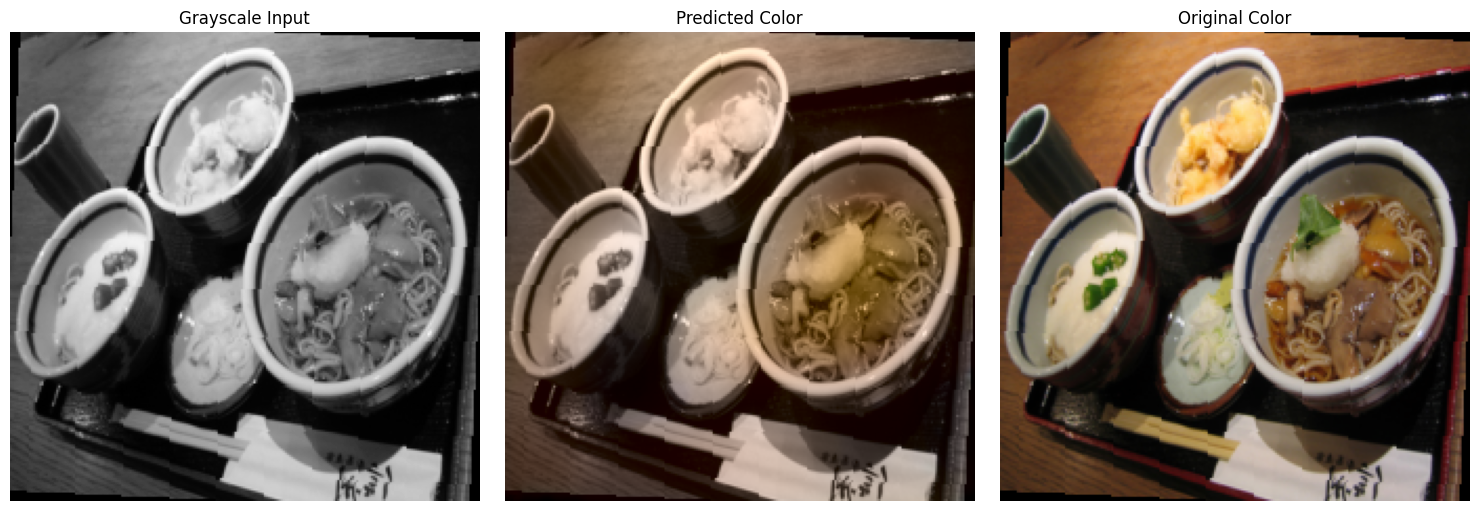

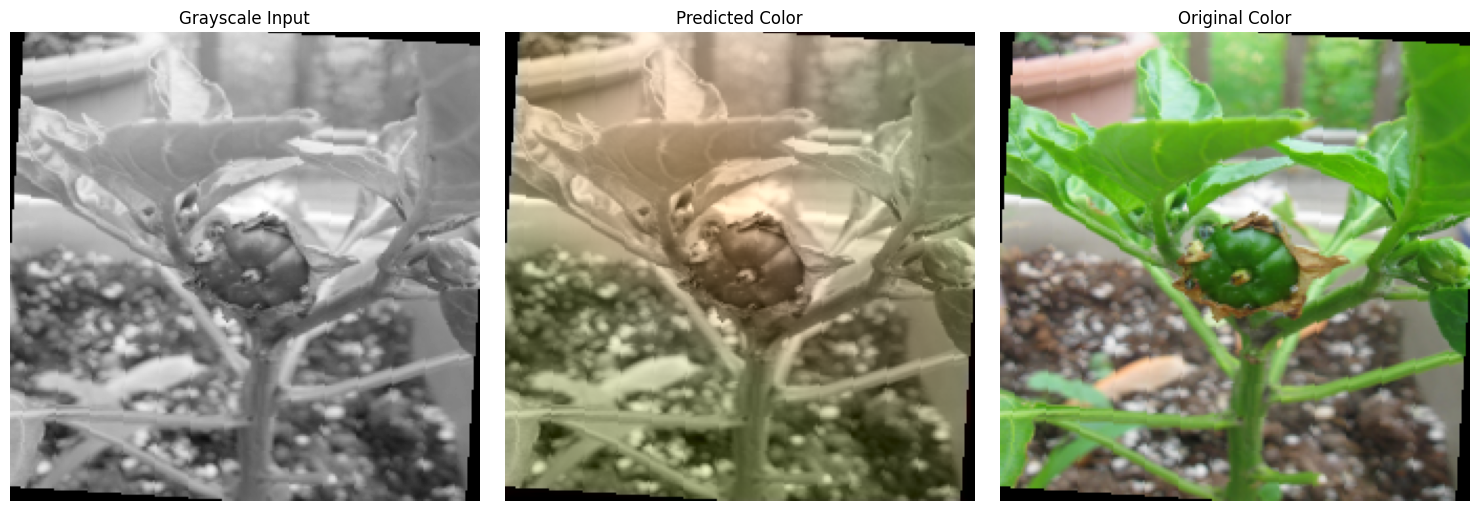

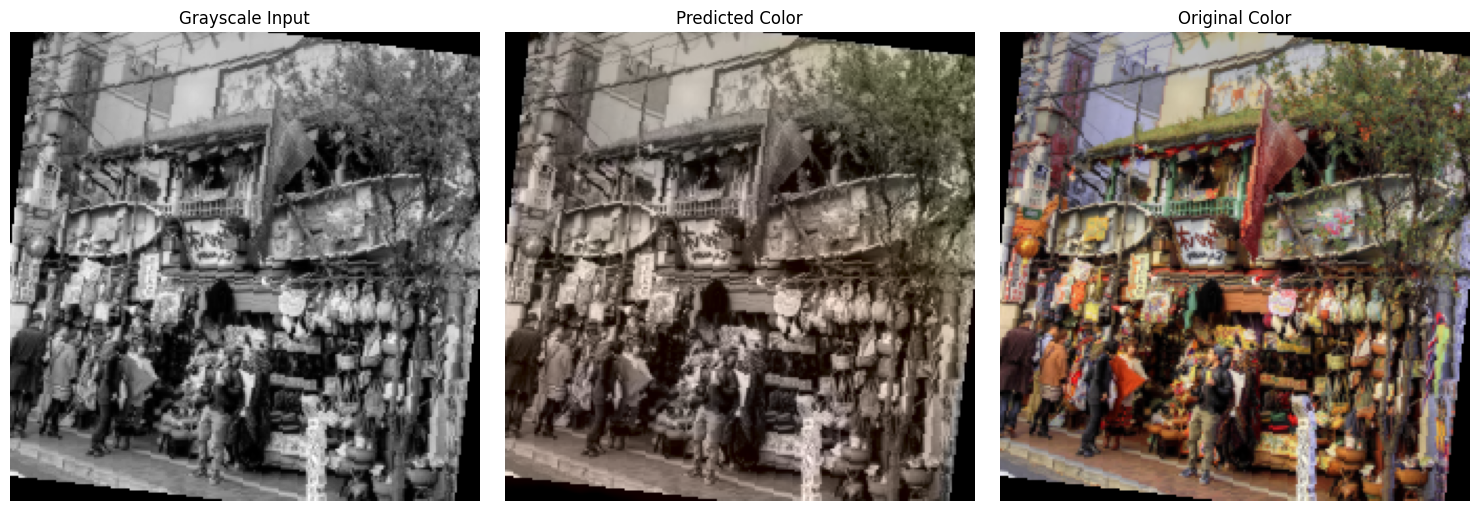

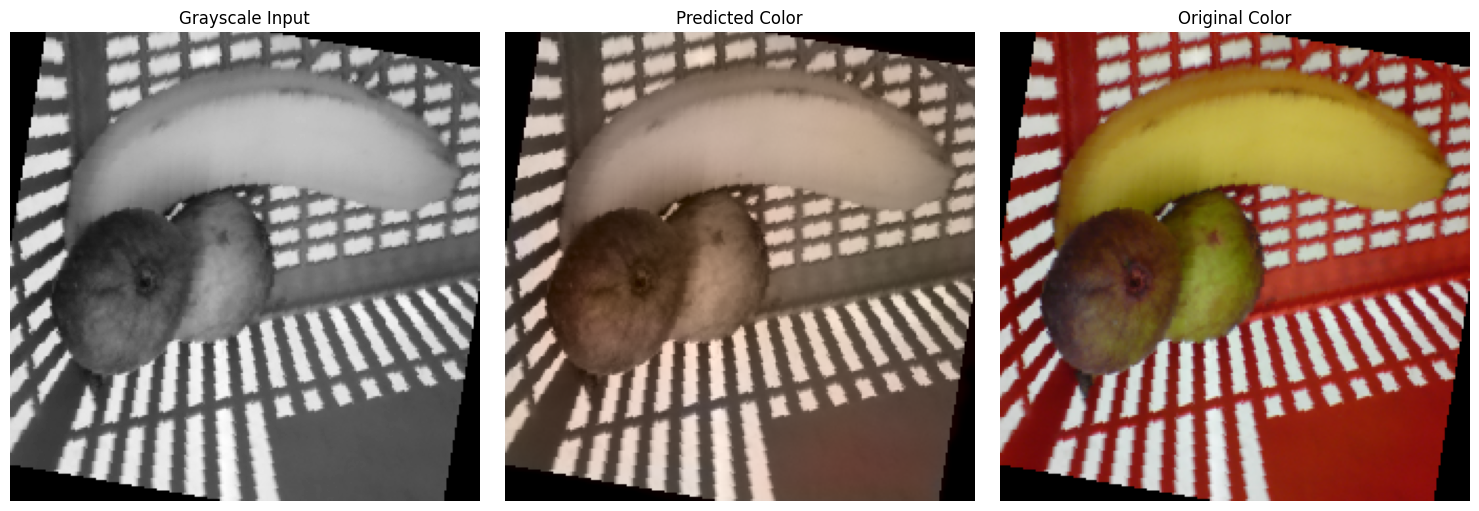

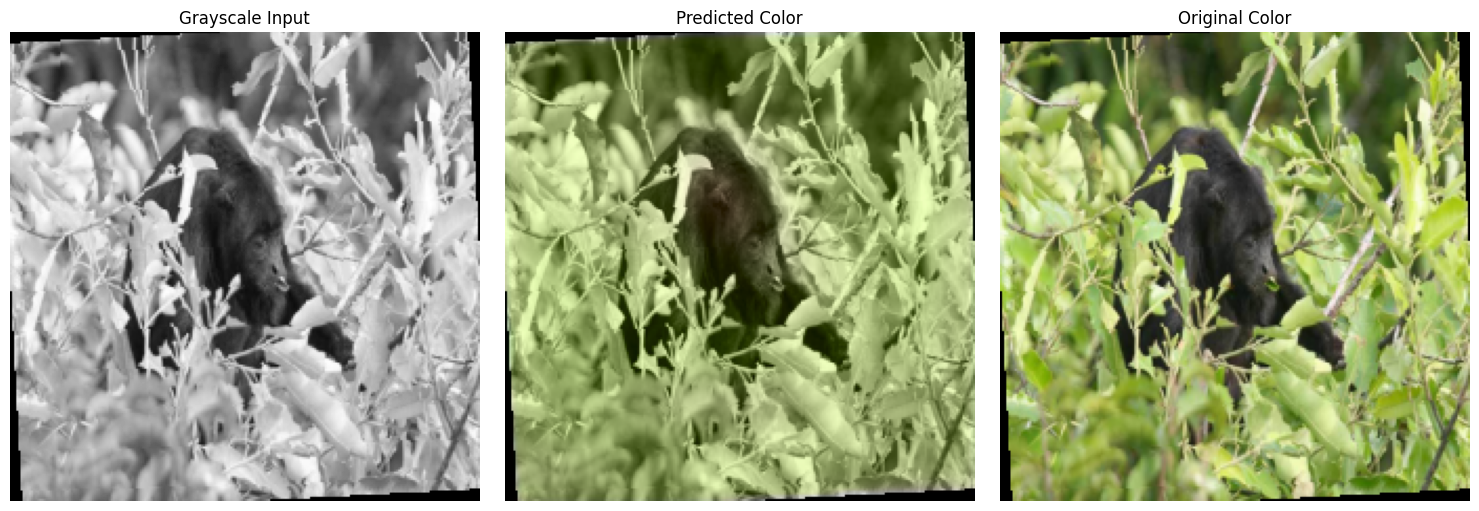

In [11]:
def visualize_output(model, dataloader, device, num_samples=5):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Randomly select `num_samples` indices from the dataset
    selected_indices = random.sample(range(len(dataloader.dataset)), num_samples)

    with torch.no_grad():
        for idx in selected_indices:
            # Retrieve the sample directly from the dataset using the index
            l_channel, ab_channels = dataloader.dataset[idx]

            # Add a batch dimension (1, 1, 224, 224) and move to the appropriate device
            l_channel = l_channel.unsqueeze(0).to(device)  # Shape: (1, 1, H, W)
            ab_channels = ab_channels.unsqueeze(0).to(device)  # Shape: (1, 2, H, W)

            # Get model predictions
            predicted_ab = model(l_channel)

            # Convert tensors to numpy arrays
            l_numpy = l_channel.cpu().numpy()
            ab_numpy = ab_channels.cpu().numpy()
            predicted_ab_numpy = predicted_ab.cpu().numpy()

            # Denormalize and combine channels
            l_numpy = (l_numpy + 1) * 50  # Convert back to [0, 100]
            ab_numpy = ab_numpy * 110  # Convert back to [-110, 110]
            predicted_ab_numpy = predicted_ab_numpy * 110  # Convert back to [-110, 110]

            # Combine L channel with ab channels for both original and predicted images
            original_lab = np.concatenate((l_numpy[0], ab_numpy[0]), axis=0).transpose(1, 2, 0)
            predicted_lab = np.concatenate((l_numpy[0], predicted_ab_numpy[0]), axis=0).transpose(1, 2, 0)

            # Convert LAB to RGB
            original_rgb = lab2rgb(original_lab)
            predicted_rgb = lab2rgb(predicted_lab)

            # Plot the results
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(l_numpy[0][0], cmap='gray')
            plt.title('Grayscale Input')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(predicted_rgb)
            plt.title('Predicted Color')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(original_rgb)
            plt.title('Original Color')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

visualize_output(model, val_loader, device)